In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/NQP.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,15.620000,15.990000,15.620000,15.980000,10.681674,13800
1,1/3/2013,15.850000,16.110001,15.850000,16.110001,10.768575,26400
2,1/4/2013,16.030001,16.219999,16.030001,16.170000,10.808681,33500
3,1/7/2013,16.200001,16.280001,16.070000,16.110001,10.768575,22500
4,1/8/2013,16.200001,16.209999,16.040001,16.139999,10.788628,18500


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: -13.009993.3, cost: -35306.871094, total money: 9986.990007
epoch: 20, total rewards: -11.729990.3, cost: -31708.525391, total money: 7167.550016
epoch: 30, total rewards: 72.600013.3, cost: -34263.839844, total money: 8821.730017
epoch: 40, total rewards: 43.980002.3, cost: -35033.929688, total money: 9595.350005
epoch: 50, total rewards: 65.340004.3, cost: -34329.320312, total money: 8909.470006
epoch: 60, total rewards: 46.479995.3, cost: -34428.863281, total money: 8823.769997
epoch: 70, total rewards: 55.729998.3, cost: -34424.535156, total money: 8735.729999
epoch: 80, total rewards: 57.799994.3, cost: -34697.929688, total money: 8970.319997
epoch: 90, total rewards: 68.649998.3, cost: -35020.515625, total money: 9254.690000
epoch: 100, total rewards: 66.240003.3, cost: -35207.339844, total money: 9451.730005
epoch: 110, total rewards: 57.360006.3, cost: -35278.964844, total money: 9497.420009
epoch: 120, total rewards: 47.240005.3, cost: -35319.406250, 

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 15.980000, total balance 9984.020000
day 2, sell 1 unit at price 16.170000, investment 1.188990 %, total balance 10000.190001,
day 4: buy 1 unit at price 16.139999, total balance 9984.050001
day 5, sell 1 unit at price 16.230000, investment 0.557622 %, total balance 10000.280001,
day 15: buy 1 unit at price 16.340000, total balance 9983.940001
day 16, sell 1 unit at price 16.250000, investment -0.550797 %, total balance 10000.190001,
day 26: buy 1 unit at price 16.030001, total balance 9984.160000
day 27, sell 1 unit at price 16.000000, investment -0.187153 %, total balance 10000.160000,
day 29: buy 1 unit at price 15.900000, total balance 9984.260000
day 30: buy 1 unit at price 15.730000, total balance 9968.530001
day 31: buy 1 unit at price 15.790000, total balance 9952.740001
day 32: buy 1 unit at price 15.610000, total balance 9937.130001
day 33: buy 1 unit at price 15.660000, total balance 9921.470001
day 37: buy 1 unit at price 15.700000, total balance 

day 193: buy 1 unit at price 12.420000, total balance 9778.480001
day 195: buy 1 unit at price 12.280000, total balance 9766.200002
day 197: buy 1 unit at price 12.180000, total balance 9754.020001
day 199, sell 1 unit at price 12.280000, investment -0.566807 %, total balance 9766.300001,
day 200, sell 1 unit at price 12.430000, investment 1.056912 %, total balance 9778.730001,
day 201: buy 1 unit at price 12.490000, total balance 9766.240002
day 202: buy 1 unit at price 12.490000, total balance 9753.750002
day 203, sell 1 unit at price 12.490000, investment 1.544712 %, total balance 9766.240002,
day 204, sell 1 unit at price 12.500000, investment 2.459018 %, total balance 9778.740002,
day 205, sell 1 unit at price 12.600000, investment 2.773248 %, total balance 9791.340002,
day 206: buy 1 unit at price 12.520000, total balance 9778.820002
day 207, sell 1 unit at price 12.610000, investment 3.445448 %, total balance 9791.430001,
day 210: buy 1 unit at price 12.540000, total balance 977

day 420, sell 1 unit at price 13.840000, investment -1.072192 %, total balance 9640.529997,
day 421, sell 1 unit at price 13.790000, investment 0.656935 %, total balance 9654.319997,
day 422: buy 1 unit at price 13.860000, total balance 9640.459997
day 423: buy 1 unit at price 13.830000, total balance 9626.629997
day 425, sell 1 unit at price 13.910000, investment 0.433209 %, total balance 9640.539997,
day 426: buy 1 unit at price 13.760000, total balance 9626.779997
day 430: buy 1 unit at price 13.530000, total balance 9613.249997
day 431: buy 1 unit at price 13.580000, total balance 9599.669997
day 432, sell 1 unit at price 13.630000, investment -1.517341 %, total balance 9613.299997,
day 433, sell 1 unit at price 13.580000, investment -1.236364 %, total balance 9626.879997,
day 437, sell 1 unit at price 13.540000, investment -1.239971 %, total balance 9640.419997,
day 439: buy 1 unit at price 13.620000, total balance 9626.799997
day 440, sell 1 unit at price 13.640000, investment -1

day 649, sell 1 unit at price 13.250000, investment 0.151175 %, total balance 9743.519999,
day 650: buy 1 unit at price 13.310000, total balance 9730.209998
day 651, sell 1 unit at price 13.240000, investment 0.914633 %, total balance 9743.449998,
day 653, sell 1 unit at price 13.300000, investment 1.371954 %, total balance 9756.749998,
day 654: buy 1 unit at price 13.300000, total balance 9743.449998
day 655: buy 1 unit at price 13.200000, total balance 9730.249998
day 656: buy 1 unit at price 13.340000, total balance 9716.909998
day 657: buy 1 unit at price 13.300000, total balance 9703.609998
day 659, sell 1 unit at price 13.250000, investment 0.531105 %, total balance 9716.859998,
day 660, sell 1 unit at price 13.270000, investment 0.378216 %, total balance 9730.129998,
day 661: buy 1 unit at price 13.270000, total balance 9716.859998
day 664: buy 1 unit at price 13.170000, total balance 9703.689998
day 665, sell 1 unit at price 13.090000, investment -0.607441 %, total balance 9716

day 868, sell 1 unit at price 15.140000, investment 1.884258 %, total balance 9782.880000,
day 872: buy 1 unit at price 15.110000, total balance 9767.770000
day 873, sell 1 unit at price 15.210000, investment 2.493261 %, total balance 9782.980001,
day 874: buy 1 unit at price 15.180000, total balance 9767.800000
day 875, sell 1 unit at price 15.100000, investment 2.027028 %, total balance 9782.900001,
day 876, sell 1 unit at price 15.170000, investment 1.743798 %, total balance 9798.070001,
day 877: buy 1 unit at price 15.250000, total balance 9782.820001
day 878, sell 1 unit at price 15.340000, investment 2.608698 %, total balance 9798.160001,
day 879, sell 1 unit at price 15.380000, investment 3.152249 %, total balance 9813.540001,
day 881: buy 1 unit at price 15.500000, total balance 9798.040001
day 883: buy 1 unit at price 15.640000, total balance 9782.400001
day 884: buy 1 unit at price 15.660000, total balance 9766.740001
day 886: buy 1 unit at price 15.560000, total balance 9751

day 1013: buy 1 unit at price 13.290000, total balance 9751.900002
day 1014: buy 1 unit at price 13.200000, total balance 9738.700002
day 1015: buy 1 unit at price 13.270000, total balance 9725.430001
day 1016, sell 1 unit at price 13.240000, investment -5.428573 %, total balance 9738.670001,
day 1017: buy 1 unit at price 13.320000, total balance 9725.350001
day 1019, sell 1 unit at price 13.230000, investment -1.635690 %, total balance 9738.580001,
day 1021: buy 1 unit at price 13.240000, total balance 9725.340001
day 1022: buy 1 unit at price 13.210000, total balance 9712.130001
day 1023, sell 1 unit at price 13.240000, investment -0.823975 %, total balance 9725.370001,
day 1024, sell 1 unit at price 13.220000, investment -0.151054 %, total balance 9738.590001,
day 1027: buy 1 unit at price 13.310000, total balance 9725.280001
day 1028: buy 1 unit at price 13.330000, total balance 9711.950001
day 1029, sell 1 unit at price 13.300000, investment 0.987093 %, total balance 9725.250001,


day 1237, sell 1 unit at price 13.360000, investment -1.692424 %, total balance 9726.970002,
day 1239: buy 1 unit at price 13.380000, total balance 9713.590002
day 1240, sell 1 unit at price 13.340000, investment -1.694912 %, total balance 9726.930002,
day 1241, sell 1 unit at price 13.400000, investment -1.033976 %, total balance 9740.330002,
day 1242: buy 1 unit at price 13.470000, total balance 9726.860002
day 1245: buy 1 unit at price 13.500000, total balance 9713.360002
day 1246: buy 1 unit at price 13.360000, total balance 9700.000002
day 1247, sell 1 unit at price 13.380000, investment -2.121434 %, total balance 9713.380002,
day 1248: buy 1 unit at price 13.300000, total balance 9700.080002
day 1249, sell 1 unit at price 13.260000, investment -3.423156 %, total balance 9713.340002,
day 1250, sell 1 unit at price 13.200000, investment -3.719914 %, total balance 9726.540002,
day 1252, sell 1 unit at price 13.130000, investment -3.879940 %, total balance 9739.670002,
day 1255, sell

day 1468, sell 1 unit at price 12.180000, investment -3.256552 %, total balance 9534.710002,
day 1471: buy 1 unit at price 12.190000, total balance 9522.520002
day 1472: buy 1 unit at price 12.210000, total balance 9510.310002
day 1473: buy 1 unit at price 12.180000, total balance 9498.130002
day 1474: buy 1 unit at price 12.240000, total balance 9485.890002
day 1475: buy 1 unit at price 12.250000, total balance 9473.640002
day 1476: buy 1 unit at price 12.260000, total balance 9461.380002
day 1477, sell 1 unit at price 12.270000, investment -1.682685 %, total balance 9473.650002,
day 1478, sell 1 unit at price 12.380000, investment -1.823946 %, total balance 9486.030003,
day 1480, sell 1 unit at price 12.310000, investment -2.146260 %, total balance 9498.340003,
day 1483: buy 1 unit at price 12.240000, total balance 9486.100003
day 1484: buy 1 unit at price 12.200000, total balance 9473.900003
day 1485: buy 1 unit at price 12.220000, total balance 9461.680003
day 1487, sell 1 unit at 

day 1710: buy 1 unit at price 14.080000, total balance 9370.880004
day 1711, sell 1 unit at price 14.090000, investment 6.580937 %, total balance 9384.970004,
day 1713: buy 1 unit at price 14.020000, total balance 9370.950004
day 1714, sell 1 unit at price 14.020000, investment 5.492856 %, total balance 9384.970004,
day 1715, sell 1 unit at price 14.060000, investment 6.920158 %, total balance 9399.030004,
day 1717, sell 1 unit at price 14.040000, investment 6.363638 %, total balance 9413.070004,
day 1718, sell 1 unit at price 14.030000, investment 6.207416 %, total balance 9427.100004,
day 1721: buy 1 unit at price 14.170000, total balance 9412.930004
day 1724, sell 1 unit at price 14.160000, investment 6.386171 %, total balance 9427.090004,
day 1726, sell 1 unit at price 14.050000, investment 4.694487 %, total balance 9441.140004,
day 1727, sell 1 unit at price 14.050000, investment 4.694487 %, total balance 9455.190004,
day 1728: buy 1 unit at price 14.050000, total balance 9441.140

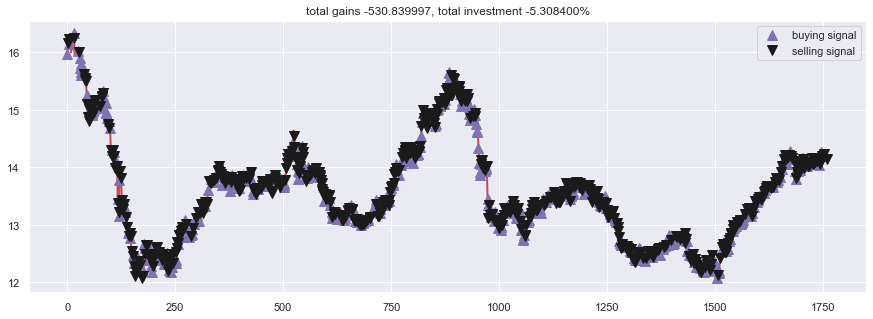

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()